In [2]:
import sys
import os
from sciviso import *
from scproximite import *

# Set-up

### Load data and create visualisation Dataframe

In [6]:
data_dir = '../results/'

all_datasets = ['Discrete_Abundant_Base_Simulation','Discrete_Abundant_70%_Simulation','Discrete_Abundant_90%_Simulation',
                'Discrete_ModeratelyRare_Base_Simulation','Discrete_ModeratelyRare_70%_Simulation','Discrete_ModeratelyRare_90%_Simulation',
                'Discrete_UltraRare_Base_Simulation','Discrete_UltraRare_70%_Simulation','Discrete_UltraRare_90%_Simulation',
                'Continuous_Abundant_Base_Simulation','Continuous_Abundant_70%_Simulation','Continuous_Abundant_90%_Simulation',
                'Continuous_ModeratelyRare_Base_Simulation','Continuous_ModeratelyRare_70%_Simulation','Continuous_ModeratelyRare_90%_Simulation',
                'Continuous_UltraRare_Base_Simulation','Continuous_UltraRare_70%_Simulation','Continuous_UltraRare_90%_Simulation']

datasets = dict.fromkeys(all_datasets, None) 

In [7]:

all_metrics = ['euclidean', 'cityblock', 'correlation', 'spearman', 'cosine', 'braycurtis', 'hamming', 'jaccard',
            'kulsinski', 'yule', 'OT', 'phi_s', 'weighted_rank', 'kendall', 'zi_kendall','canberra', 'chebyshev']

eval_metrics=['PSI']

k_vals = ["3K_stats", '10K_stats', "30K_stats", "50K_stats"]

for dataset in datasets.keys():
    datasets[dataset] = load_pickle(dataset, data_dir, mode='mean', metrics= all_metrics,eval_metrics=eval_metrics,k_vals=k_vals)

In [8]:
df = vis_dataframe(datasets=all_datasets, datasets_dict=datasets, metrics=all_metrics, k_vals=k_vals, eval_metrics=eval_metrics)

#Create visualisation dataframe for supplementary Figure 12 (heatmap):
k30_df = vis_dataframe(datasets=all_datasets, datasets_dict=datasets, metrics=all_metrics, k_vals=['30K_stats'], eval_metrics=eval_metrics)

In [9]:
#Get the mean PSI for each metric, grouped by dataset across all k values:
mean_df = df.groupby(['Metric','Dataset'])['Performance'].describe()
mean_df['ID'] = mean_df.index.map(lambda x: '_'.join([str(i) for i in x]))
dat = mean_df.reset_index()
dat = dat[['mean', 'ID']]

df['ID'] = df['Metric'].str.cat(df[['Dataset']], sep='_')
vis_df = df.merge(dat, how='inner', on='ID')

### Visualisation Aesthetics

In [10]:
#Set directory to save figures to:
figure_dir = ''

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 300

# Set to true if you want to save figures out:
save = False

#heatmap settings
heatmap_config = {
    'title_font_size': 15,
    'label_font_size': 12,
    'axis_font_size': 10,
    's': 60,
    'figsize': (15, 10),
}

#Seaborn theme and context:
sns.set_context("notebook")
sns.set_style("darkgrid",{'ytick.left': True,'xtick.bottom': True, 'axes.linewidth':1, 'axes.edgecolor':'black'})


#Colour dictionary for Metrics:
colour_dict = {'euclidean':'#393b79', 'cityblock':'#6b6ecf', 'correlation':'#637939', 'spearman':'#b5cf6b', 'cosine':'#e6550d',
          'braycurtis':'#843c39', 'hamming':'#d6616b', 'jaccard':'#31a354', 'kulsinski':'#7b4173', 'yule':'#ce6dbd',
          'OT':'#e7ba52', 'phi_s':'#3182bd','weighted_rank':'#e7969c', 'kendall':'#fdae6b', 'zi_kendall':'#9467bd',
          'canberra':'#8c6d31', 'chebyshev':'#636363'}

#Colour scale for heatmaps:
base_scale = 'viridis'

# Figure 6

In [11]:
#Subset dataframe to only contain the moderately-sparse (70%) datasets, & remove unnecessary columns/duplicates:
delta_df = vis_df[vis_df['Property'] == '70%'].drop(labels = ['Performance','k_value','Evaluation_Metric', 'Condition',
                                 'Property','ID', 'Dataset'], axis = 1)
delta_df = delta_df.drop_duplicates(keep='first')

#Reform dataframe
for index, row in delta_df.iterrows():
        met = row['Metric']
        con = row['Data_Structure']
        Abundant = delta_df.query(f"Metric == '{met}' and Population_Balance == 'Abundant' and Data_Structure =='{con}'")
        Rare = delta_df.query(f"Metric == '{met}' and Population_Balance == 'ModeratelyRare' and Data_Structure =='{con}'")
        UltraRare = delta_df.query(f"Metric == '{met}' and Population_Balance == 'UltraRare' and Data_Structure =='{con}'")
        delta_df.loc[index,'Abundant'] = Abundant['mean'].values
        delta_df.loc[index,'ModeratelyRare']  = Rare['mean'].values
        delta_df.loc[index,'UltraRare'] = UltraRare['mean'].values

In [12]:
#Seperate dataframe by structure
Disc = delta_df[delta_df['Data_Structure'] == 'Discrete']
Cont = delta_df[delta_df['Data_Structure'] == 'Continuous']

In [13]:
#For each structure-specific dataset, sort metrics by their performance in the Ultra-Rare subset, and filter to only retain the top 5:
new_dfs = []
for data in [Disc, Cont]:
    data = data.sort_values(by=['UltraRare'], ascending=False) #sort by D1 values
    data.reset_index(drop=True,inplace=True) #reset the index so it matches the new sort
    data['UR_rank'] = data.index #set new column called D1_rank to index values
    data = data[0:15]
    new_dfs.append(data)
    
#Concatenate data
filtered_data = pd.concat(new_dfs)
#Ensure dataframe is correctly sorted:
filtered_data['Data_Structure'] = pd.Categorical(filtered_data['Data_Structure'], categories=['Discrete', 'Continuous'], ordered=True)
filtered_data = filtered_data.sort_values(['Metric','Data_Structure']).reset_index(drop=True)

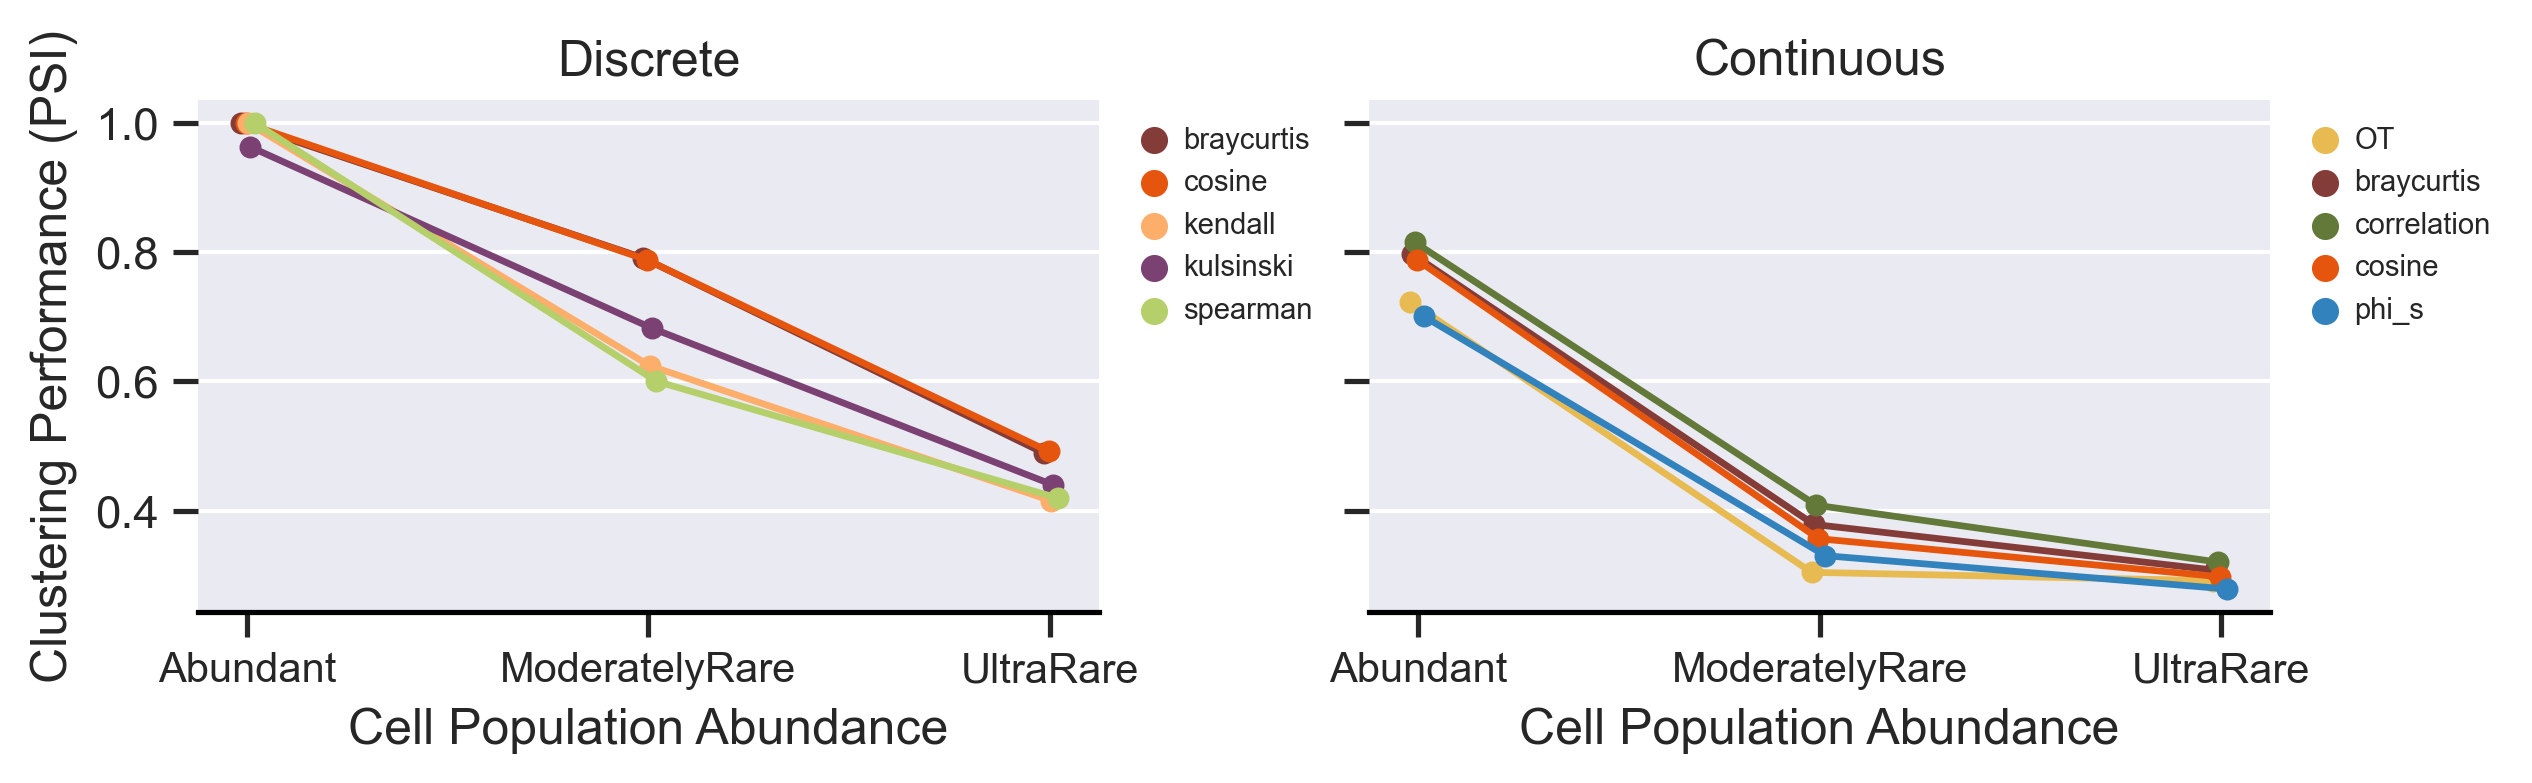

In [14]:
data = filtered_data

g = sns.catplot(x = "Population_Balance",                  
                y = 'mean', 
                data = data,
                hue = 'Metric',
                col = 'Data_Structure',
                col_order = ['Discrete','Continuous'],
                col_wrap = 2,
                palette = colour_dict,
                s=10,
                kind='point',
                join=True,
                order = ['Abundant', 'ModeratelyRare', 'UltraRare'],
                dodge=0.04,
                aspect = 1.7,
                sharey = True,
                height = 2.3,
                scale = 0.6,
                ci=None,
                legend_out = False).despine(left=True)



#### To produce individual legends for each subplot: ######
# MASTER SERIES OF serial
ser_vals = pd.Series(data['Metric'].sort_values().unique())

for axes, (i, d) in zip(g.axes.ravel(), data.groupby(['Data_Structure'])):
    handles, labels = axes.get_legend_handles_labels()

    # SUBSET MASTER SERIES OF serial
    vals = ser_vals[ser_vals.isin(d['Metric'].unique())]    
    idx = vals.index.tolist()
    axes.margins(x=0.05)
    #axes.yaxis.set_tick_params(which='both', labelbottom=True)
    #axes.xaxis.set_tick_params(which='both', labelbottom=True)

    if len(idx) > 0:
        axes.legend(handles = [handles[i] for i in idx], labels = vals.tolist(), bbox_to_anchor=(1, 1), prop={'size': 7},
                    loc=2,markerscale=1.3,facecolor='white',handletextpad=0, frameon = False)
################################################################

g.fig.subplots_adjust(bottom=0.09, wspace=0.3,hspace=0.3)

g.set_xlabels('Cell Population Abundance', fontsize=12)
g.set_xticklabels(fontsize=10)
g.set_ylabels('Clustering Performance (PSI)',fontsize=12)
g.set_titles(template='{col_name}')

if save is True:
    plt.savefig(f'{fig_dir}Figure_6.svg',  bbox_inches = 'tight')
    plt.savefig(f'{fig_dir}Figure_6.png',  bbox_inches = 'tight', dpi=300)


# Supplementary Figure 7

In [15]:
delta_df = vis_df.drop(labels = ['Performance','k_value','Evaluation_Metric', 'Condition',
                                'ID', 'Dataset'], axis = 1)
delta_df = delta_df.drop_duplicates(keep='first')

In [16]:
Disc = delta_df [delta_df ['Data_Structure'] == 'Discrete']
Cont = delta_df [delta_df ['Data_Structure'] == 'Continuous']

In [18]:
import warnings
# Ignore setting with copy warning
warnings.simplefilter(action='ignore')

#Reform Disc dataframe
for index, row in Disc.iterrows():
        met = row['Metric']
        con = row['Property']
        Abundant = Disc.query(f"Metric == '{met}' and Population_Balance=='Abundant' and Property=='{con}'")
        Rare = Disc.query(f"Metric == '{met}' and Population_Balance=='ModeratelyRare' and Property=='{con}'")
        UltraRare = Disc.query(f"Metric == '{met}' and Population_Balance=='UltraRare' and Property=='{con}'")
        Disc.loc[index,'Abundant'] = Abundant['mean'].values
        Disc.loc[index,'ModeratelyRare']  = Rare['mean'].values
        Disc.loc[index,'UltraRare'] = UltraRare['mean'].values

In [19]:
#Reform Cont dataframe
for index, row in Cont.iterrows():
        met = row['Metric']
        con = row['Property']
        Abundant = Cont.query(f"Metric == '{met}' and Population_Balance=='Abundant' and Property=='{con}'")
        Rare = Cont.query(f"Metric == '{met}' and Population_Balance=='ModeratelyRare' and Property=='{con}'")
        UltraRare = Cont.query(f"Metric == '{met}' and Population_Balance=='UltraRare' and Property=='{con}'")
        Cont.loc[index,'Abundant'] = Abundant['mean'].values
        Cont.loc[index,'ModeratelyRare']  = Rare['mean'].values
        Cont.loc[index,'UltraRare'] = UltraRare['mean'].values

In [20]:
filtered_data = pd.concat([Disc, Cont])

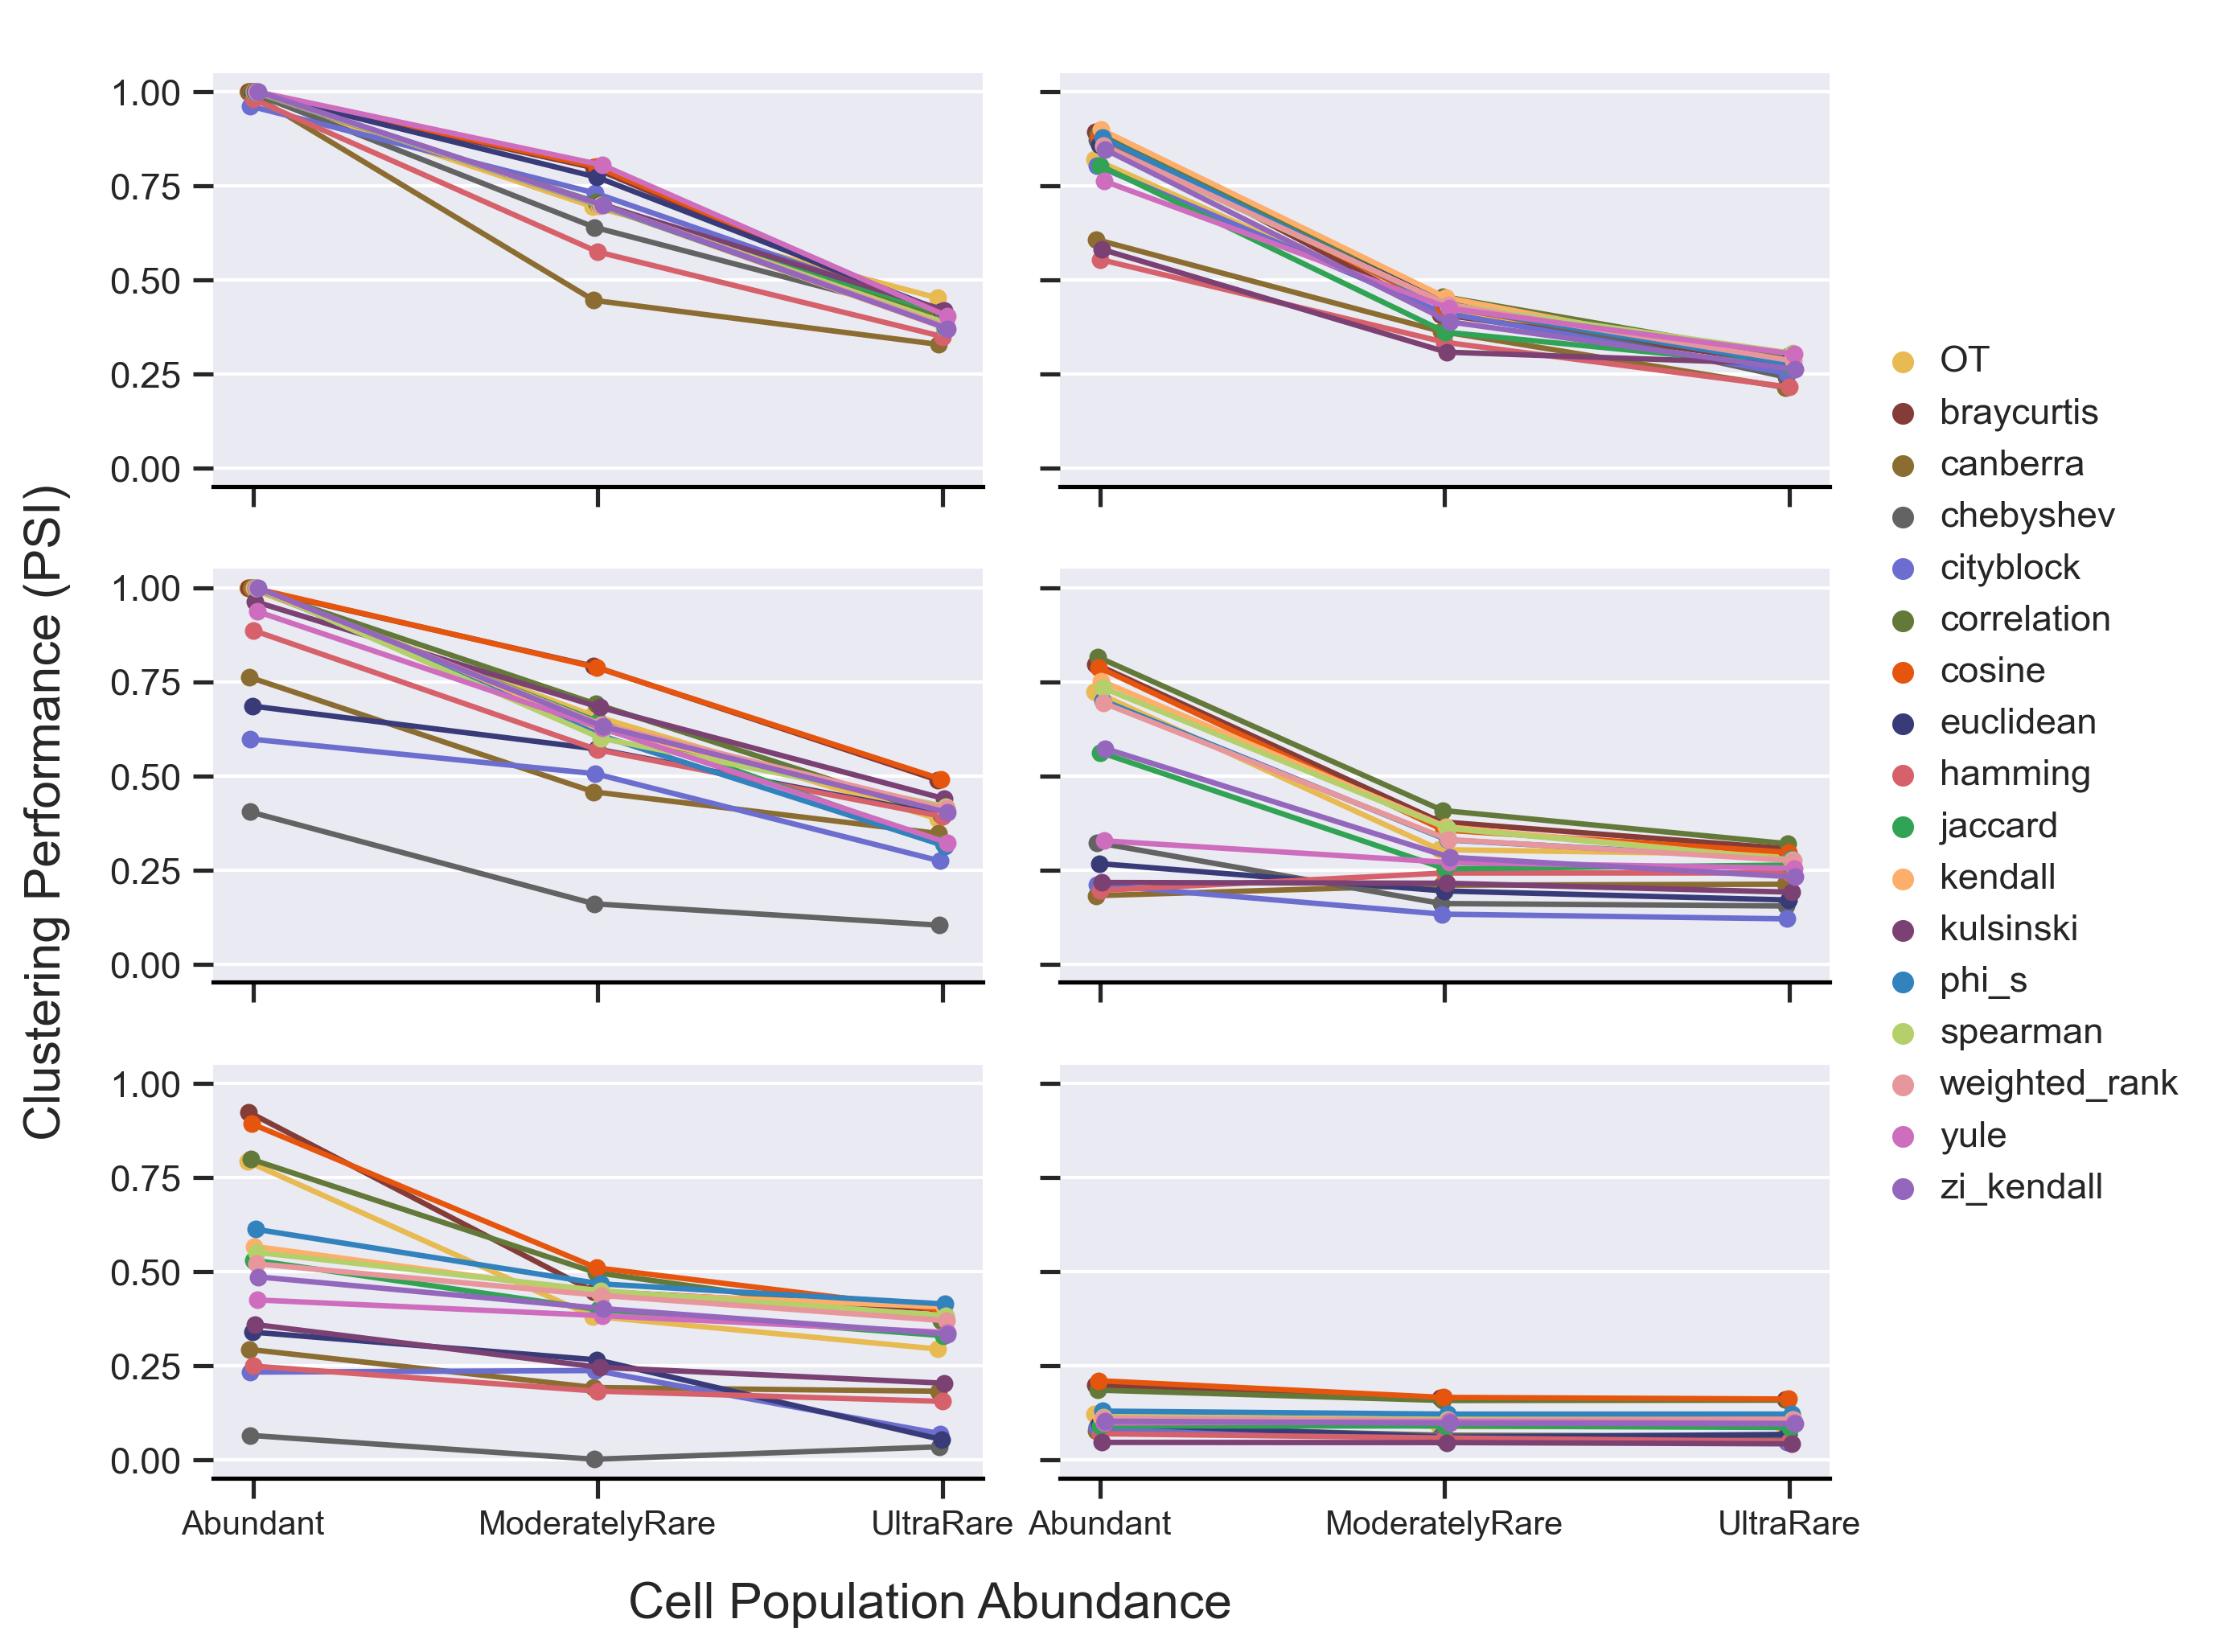

In [21]:
data = filtered_data

g = sns.catplot(x = 'Population_Balance',                  
                y = 'mean', 
                data = data,
                hue = 'Metric',
                col = 'Data_Structure',
                col_order = ['Discrete', 'Continuous'],
                row = 'Property',
                row_order = ['Base', '70%', '90%'],
                palette = colour_dict,
                s=10,
                kind='point',
                join=True,
                order = ['Abundant', 'ModeratelyRare', 'UltraRare'],
                dodge=0.03,
                aspect = 1.7,
                sharey = True,
                height = 2.3,
                scale = 0.6,
                legend=False,
                legend_out = False).despine(left=True)


for axes, (i, d) in zip(g.axes.ravel(), data.groupby(['Data_Structure'])):
    handles, labels = axes.get_legend_handles_labels()
    axes.margins(x=0.05)
    #axes.yaxis.set_tick_params(which='both', labelleft=True)
    #axes.xaxis.set_tick_params(which='both', labelbottom=True)
       
g.fig.subplots_adjust(left=0.12,bottom=0.1,wspace=0.1,hspace=0.2)
g.fig.legend(handles = handles, bbox_to_anchor=(1.18,0.8),
                    prop={'size': 11},markerscale=1.3,
             facecolor='white',handletextpad=0,frameon=False)

g.set(ylim=(None,None))
g.set_titles(template=' ')
g.set_ylabels('')
g.set_xlabels(' ')
g.set_xticklabels(fontsize=10)

g.fig.supxlabel('Cell Population Abundance',fontsize=15)
g.fig.supylabel('Clustering Performance (PSI)', fontsize=15)

if save is True:
    plt.savefig(f'{fig_dir}Figure_Sup7.svg',  bbox_inches = 'tight')
    plt.savefig(f'{fig_dir}Figure_Sup7.png',  bbox_inches = 'tight', dpi=300)

# Figure 10 Panel A

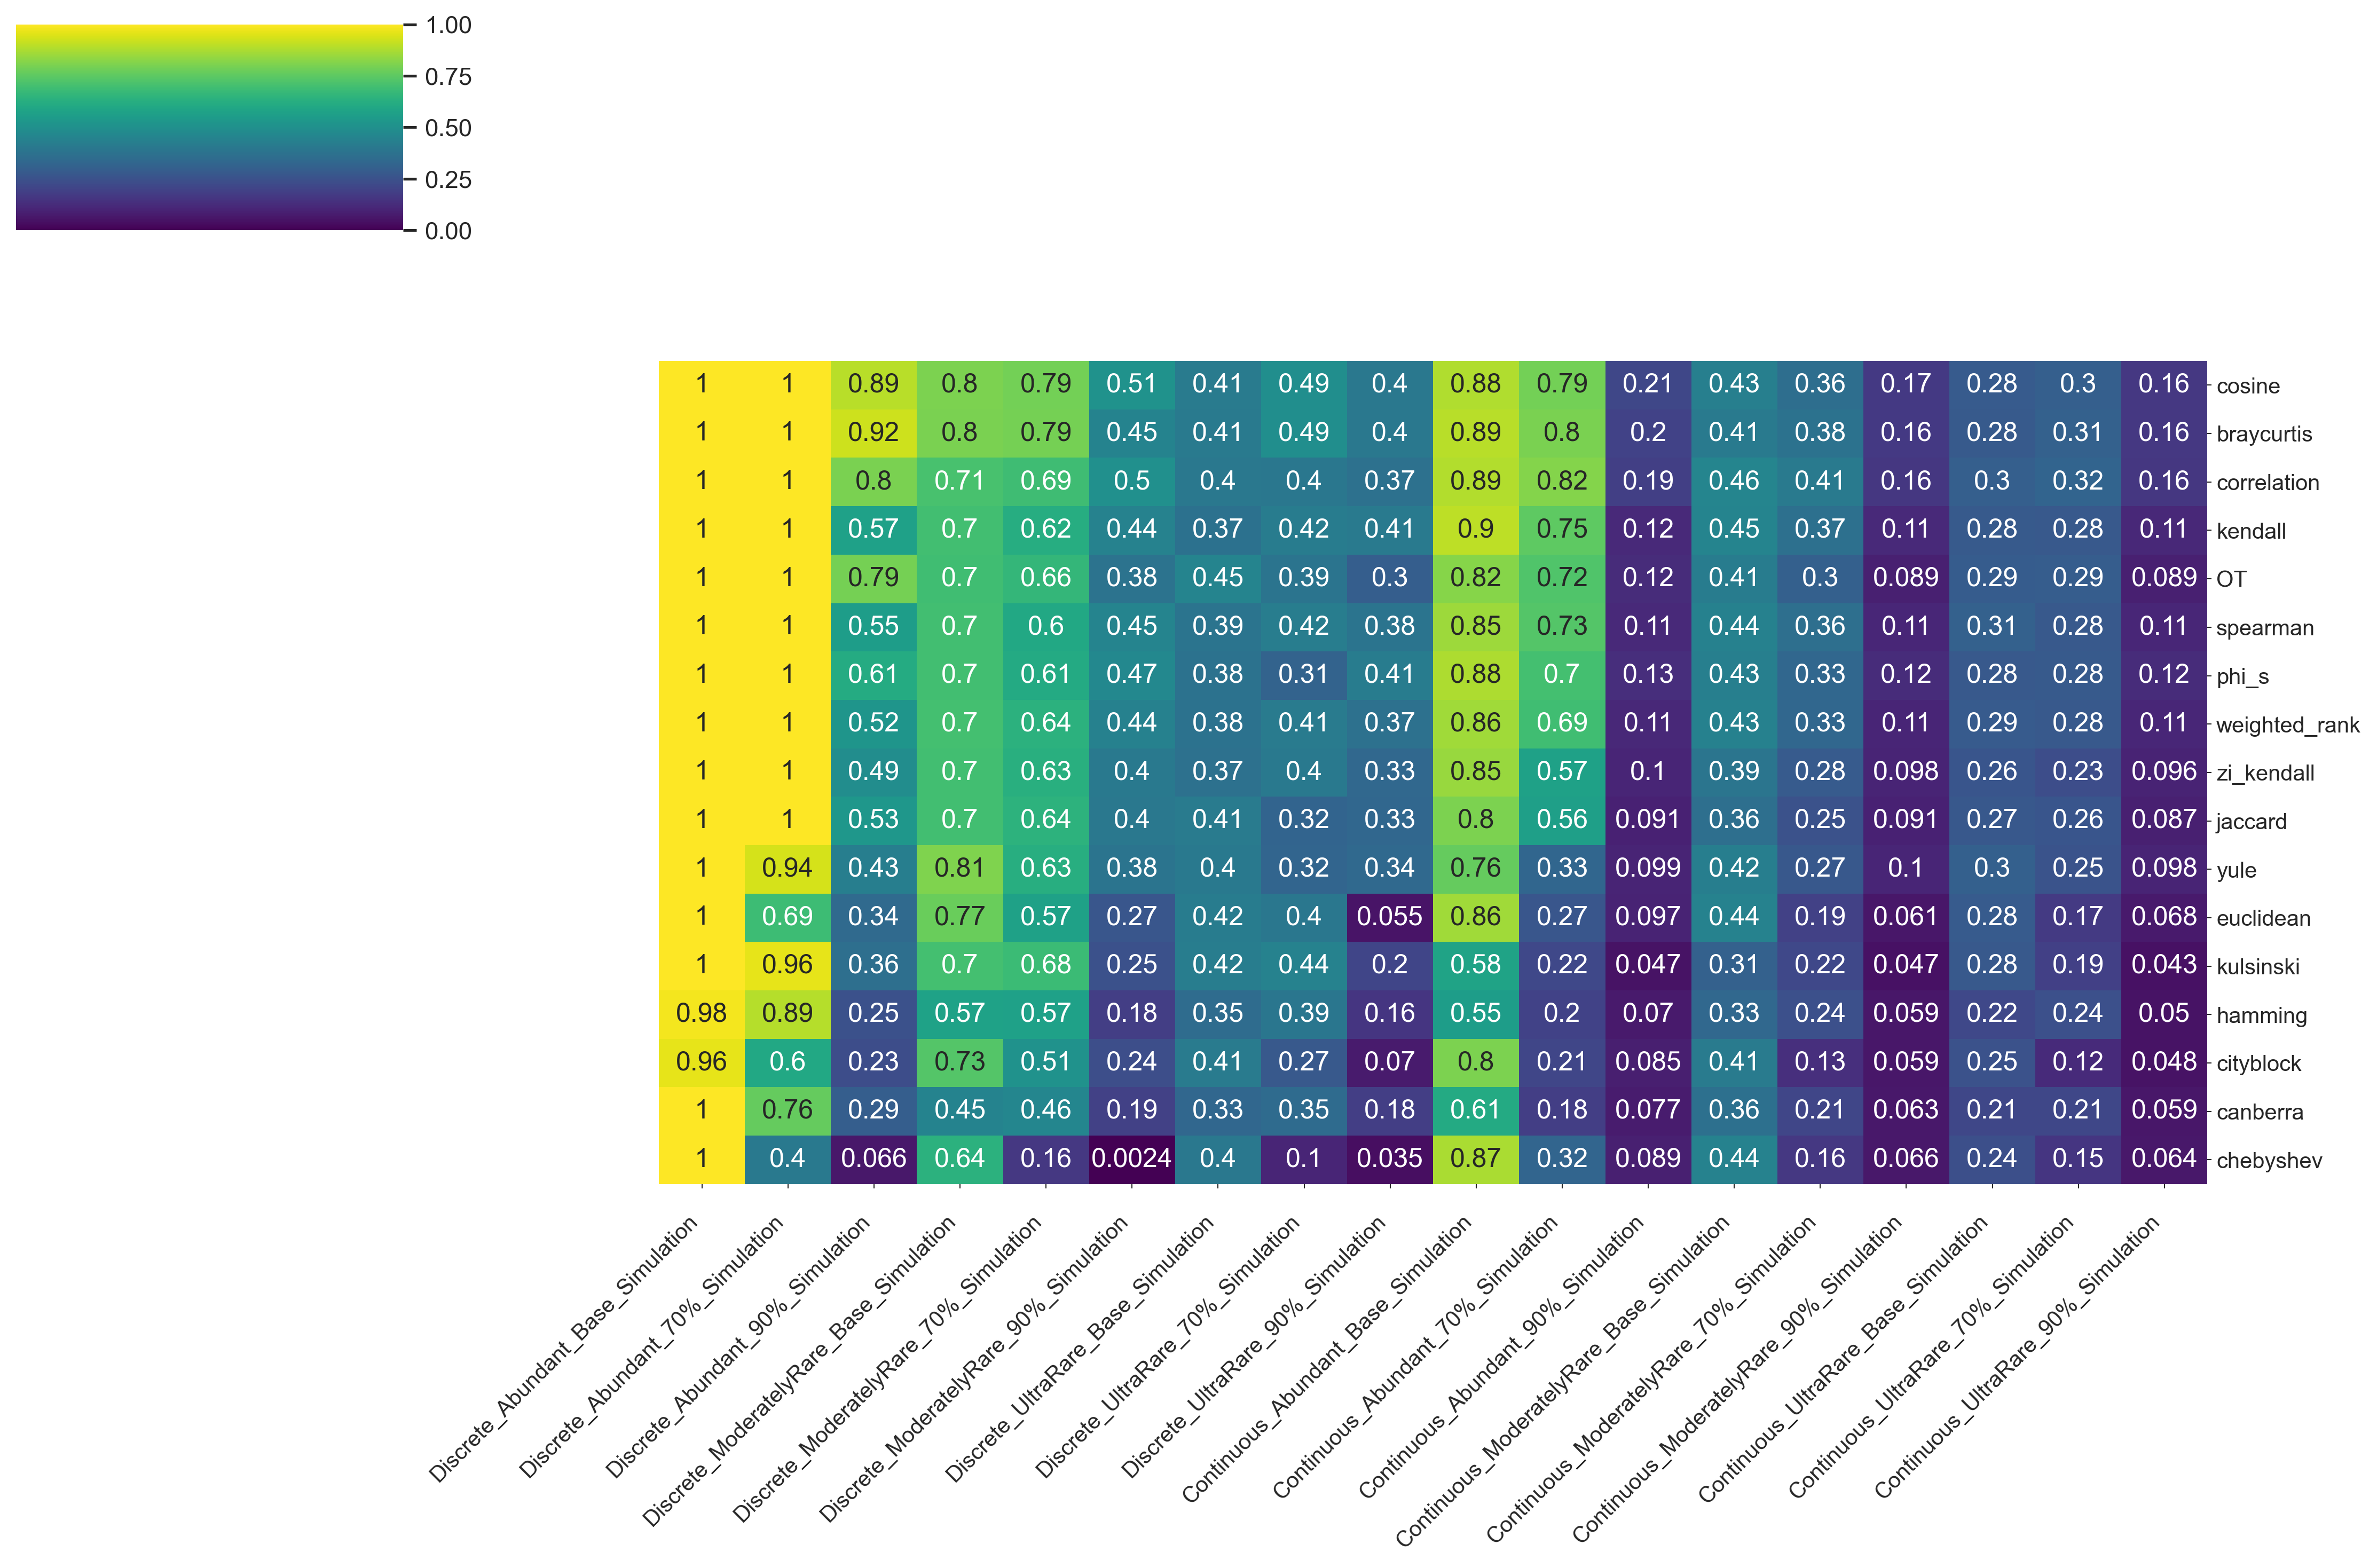

In [22]:
#Drop unnecessary columns & remove duplicates:
heat_df = vis_df.drop(labels = ['Performance','k_value','Evaluation_Metric',
                                 'Population_Balance', 'Data_Structure', 'Condition', 'ID', 'Property'], axis = 1)
heat_df = heat_df.drop_duplicates(keep='first').set_index('Metric')

#Reform dataframe:
heat_df = heat_df.pivot(columns='Dataset', values='mean').reindex(columns=all_datasets)

#Sort metrics by mean best performing across all datasets:
heat_df['metric_avg'] = np.mean(heat_df.values, axis=1)
heat_df = heat_df.sort_values(by=['metric_avg'], ascending=False)
heat_df['metric'] = heat_df.index

heatmap = Heatmap(heat_df,chart_columns=all_datasets,
                  row_index='metric',
                  cmap=base_scale, 
                  vmin=0, vmax=1, 
                  annot = True,
                  cluster_rows=False, cluster_cols=False, 
                 config=heatmap_config)
ax = heatmap.plot()
ax.ax_heatmap.tick_params(axis='x', which='major', pad=10)
if save is True:
    plt.savefig(f'{fig_dir}Figure_10A.png',  bbox_inches = 'tight', dpi=300)
    plt.savefig(f'{fig_dir}Figure_10A.svg',  bbox_inches = 'tight')
plt.show()

# Supplementary Figure 11 Panel A

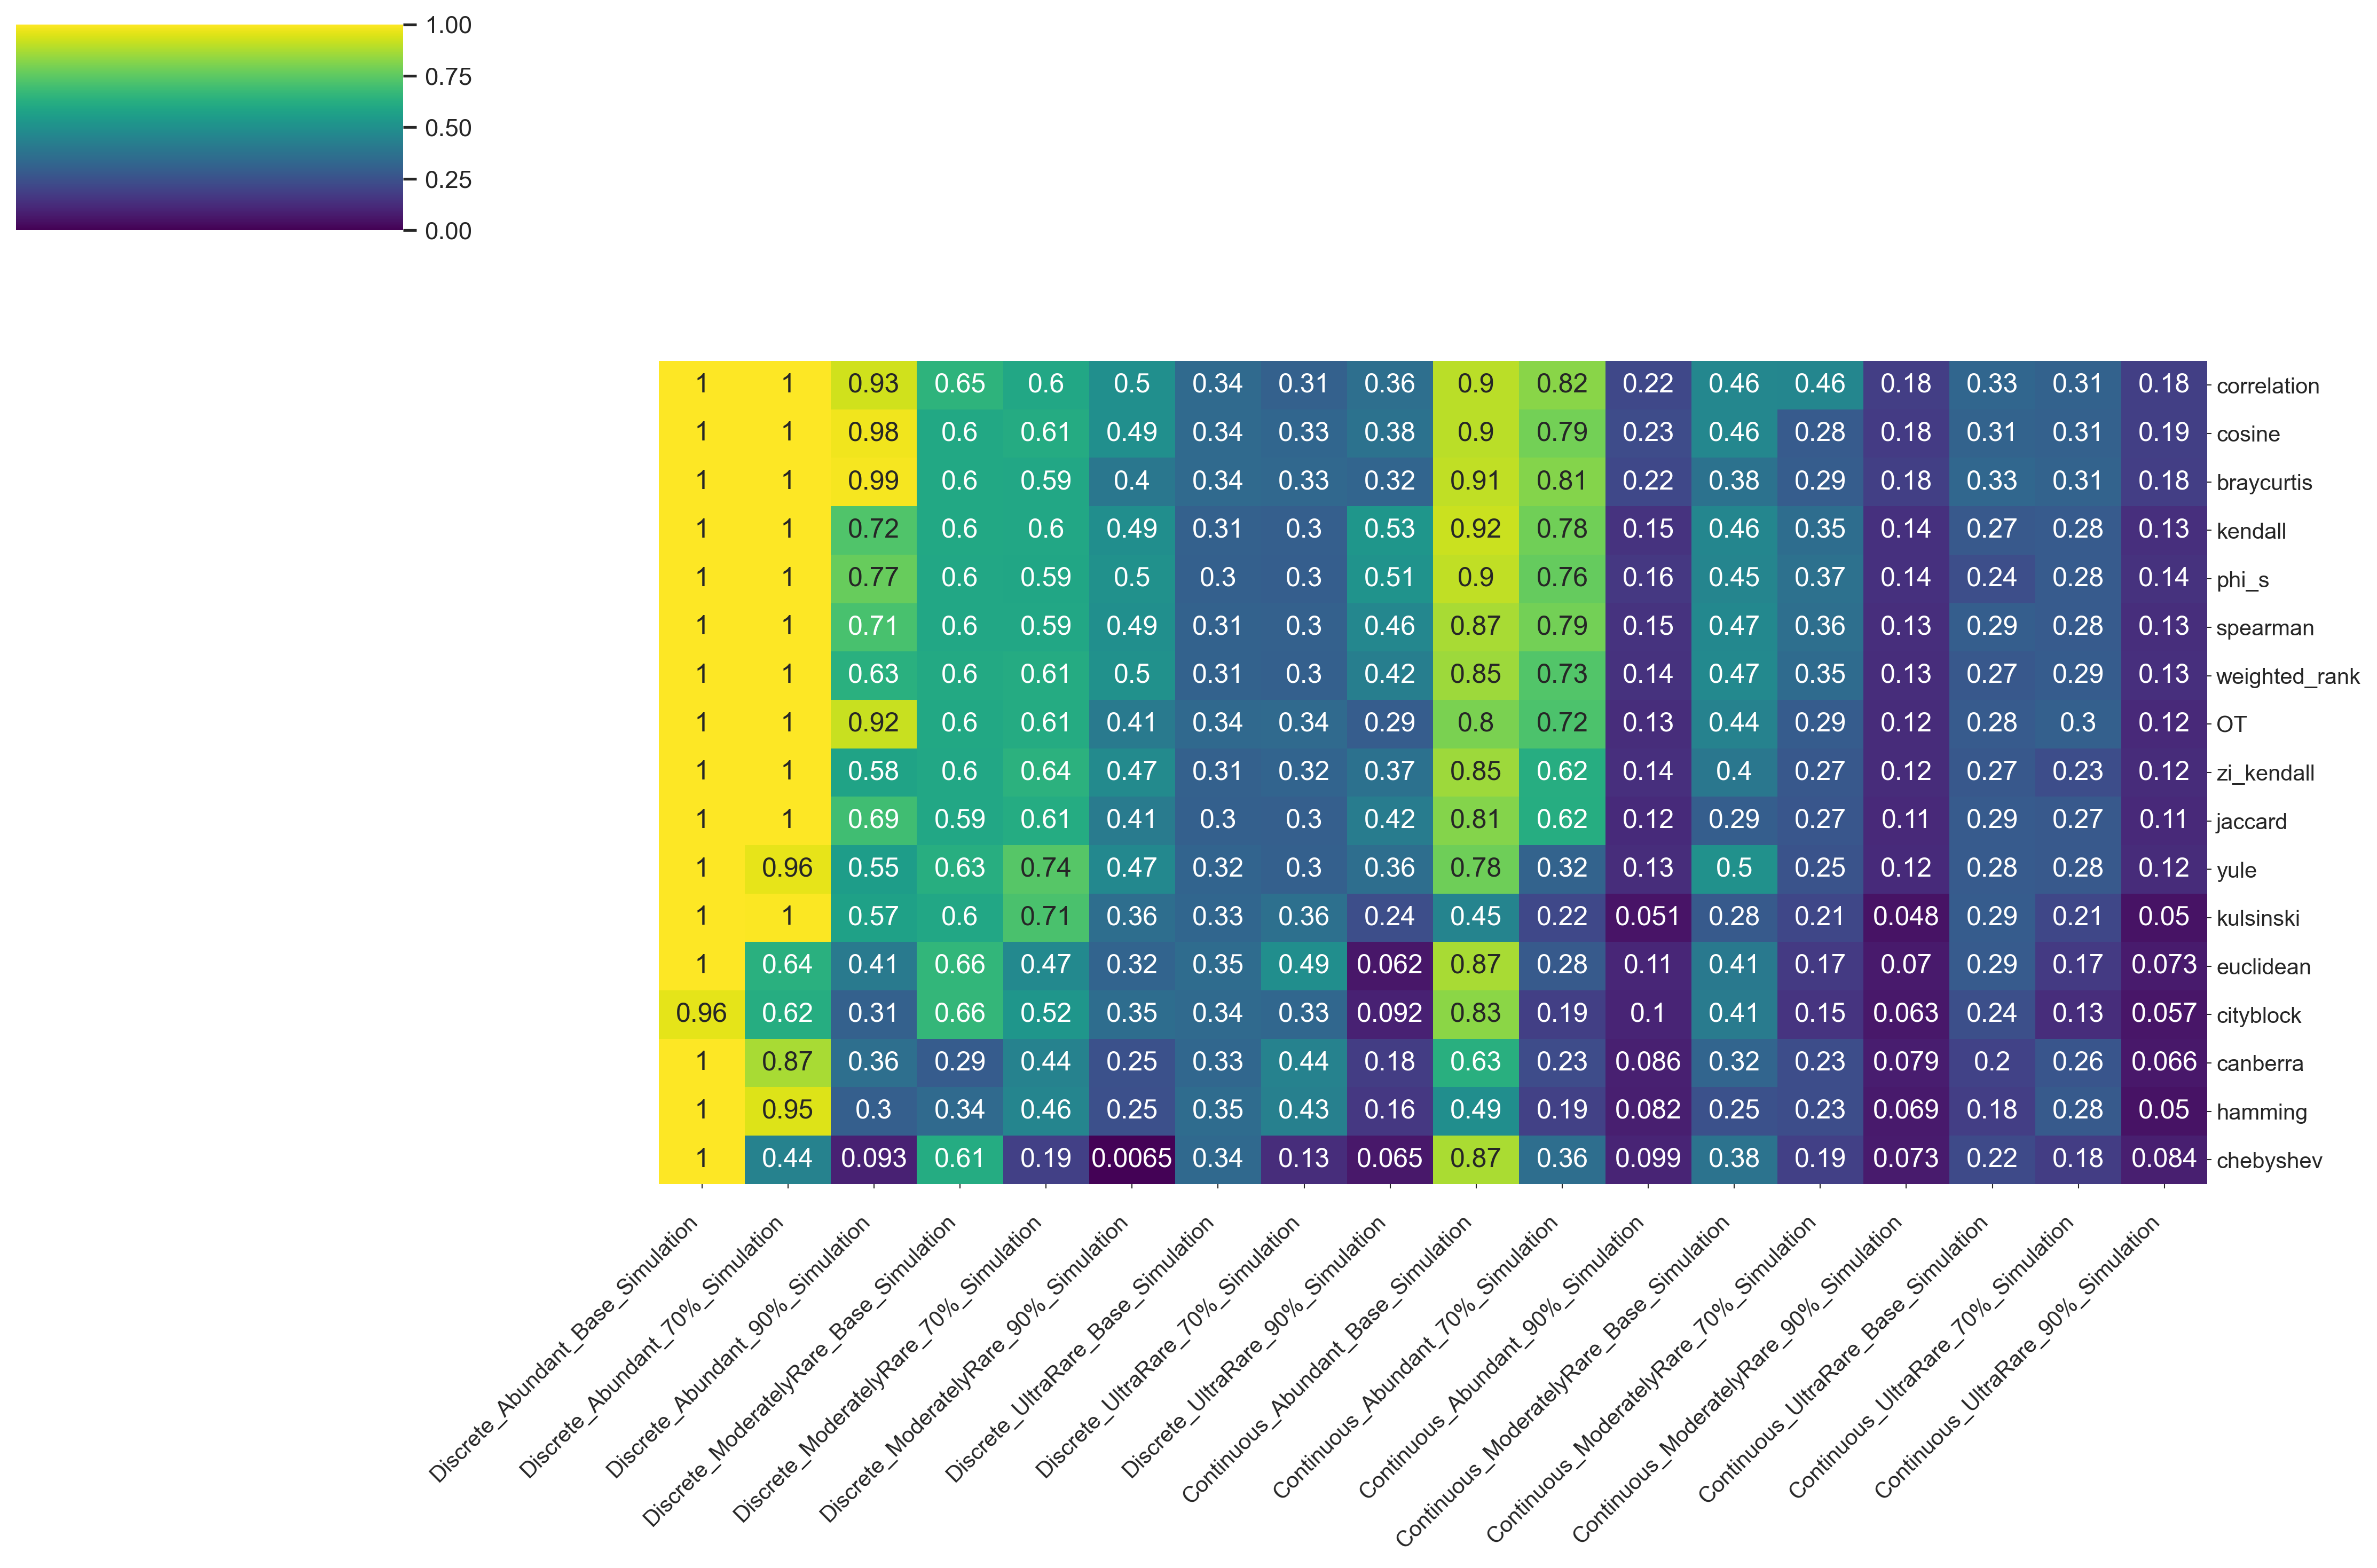

In [23]:
heat_df = k30_df.drop(labels = ['Evaluation_Metric', 'Data_Structure', 'Population_Balance', 'Condition', 'Property', 'k_value'], axis = 1).set_index('Metric')

heat_df = heat_df.pivot(columns='Dataset', values='Performance').reindex(columns=all_datasets)

heat_df['metric_avg'] = np.mean(heat_df.values, axis=1)
heat_df = heat_df.sort_values(by=['metric_avg'], ascending=False)
heat_df['metric'] = heat_df.index

heatmap = Heatmap(heat_df,chart_columns=all_datasets,
                  row_index='metric',
                  cmap=base_scale, 
                  vmin=0, vmax=1, 
                  annot = True,
                  cluster_rows=False, cluster_cols=False, 
                 config=heatmap_config)
ax = heatmap.plot()
ax.ax_heatmap.tick_params(axis='x', which='major', pad=10)
if save is True:
    plt.savefig(f'{fig_dir}Figure_Sup11A.png',  bbox_inches = 'tight', dpi=300)
    plt.savefig(f'{fig_dir}Figure_Sup11A.svg',  bbox_inches = 'tight')
plt.show()